In [2]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn

In [3]:
#hyper params
lr = 1e-5
wd = 1e-2
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 40
classes = ['irrelevant','relevant'] #arranged in order of their placement in the folder
num_classes = len(classes)
path = 'balanced_binary_dataset'
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss


In [4]:

def get_dataset(path,val_split,test_split):
    transform_weak = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                               ])

    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset_strong = datasets.ImageFolder(path,transform=transform_strong)
    dataset_weak = datasets.ImageFolder(path,transform=transform_weak)

    trainset_strong,valset_strong,testset_strong = stratified(dataset_strong)
    trainset_weak,valset_weak,testset_weak = stratified(dataset_weak)
    
    print("train strong:",len(trainset_strong),"val strong:",len(valset_strong),"test strong:",len(testset_strong))
    print("train weak:",len(trainset_weak),"val weak:",len(valset_weak),"test strong:",len(testset_weak))

    
    return trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset_strong, valset_strong, trainset_weak,valset_weak, model, criterion, optimizer, scheduler, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset_strong, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_strong, batch_size=bs, shuffle=True)
    }

    dataloaders_weak = {
        'train': data.DataLoader(trainset_weak, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_weak, batch_size=bs, shuffle=True)
    }
    dataset_sizes_strong = {'train': len(trainset_strong), 'val': len(valset_strong)}
    dataset_sizes_weak = {'train': len(trainset_weak), 'val': len(valset_weak)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloaders_strong[phase],dataloaders_weak[phase]):
                inputs_strong = inputs_strong.to(device)
                inputs_weak = inputs_weak.to(device)                
                labels_weak = labels_weak.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_weak = model(inputs_weak)
                    _, preds_weak = torch.max(outputs_weak, 1)

                    #loss = criterion(outputs_weak, labels_weak)



                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs_weak, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    
                    
                    if skip_mask.sum().item() > 0:
                        c += 1
                        inputs_weak = inputs_weak[skip_mask]
                        labels_weak = labels_weak[skip_mask]
                        preds_weak = preds_weak[skip_mask]
                        #loss = criterion(outputs_weak[skip_mask], labels_weak)
                    
                    #skip_mask = skip_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand_as(inputs)  # Expand mask dimensions

                    # AdaMatch steps
                    outputs_strong = model(inputs_strong)
                    pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
                    max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
                    mask = max_probs.ge(0.95).float()

                    unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()
                    loss = lambda_u * unsupervised_loss

                    outputs_strong = pseudo_labels.clone().detach()
                    inputs = torch.cat([inputs_weak, inputs_strong])
                    labels = torch.cat([labels_weak, outputs_strong])

                    supervised_outputs = model(inputs)
                    _, supervised_preds = torch.max(supervised_outputs, 1)
                    supervised_loss = criterion(supervised_outputs, labels)
                    loss += supervised_loss

                    # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                    unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                    unique_classes_true = np.unique(labels.cpu().numpy())

                    if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                        balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                    else:
                        balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true

                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(supervised_preds.cpu().tolist())
                    
                    # Backpropagation and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(supervised_preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(supervised_outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
            epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
            epoch_entropy /= (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]) # Calculate average epoch entropy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_train.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_val.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('Number of skipped:', c)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val
    )
  

In [7]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

              
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array(model,models,dataset_strong, dataset_weak):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader_strong = data.DataLoader(dataset_strong,batch_size=bs,shuffle=True)
    dataloader_weak = data.DataLoader(dataset_weak,batch_size=bs,shuffle=True)
    
    for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloader_strong,dataloader_weak):
        inputs_strong = inputs_strong.to(device)
        inputs_weak = inputs_weak.to(device)                
        labels_weak = labels_weak.to(device)
        
        predictions = set()
        with torch.set_grad_enabled(False):
             # AdaMatch steps
            outputs_strong = model(inputs_strong)
            pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
            mask = max_probs.ge(0.95).float()

            unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()

            outputs_strong = pseudo_labels.clone().detach()
            inputs = torch.cat([inputs_weak, inputs_strong])
            labels = torch.cat([labels_weak, outputs_strong])

            supervised_outputs = models[0](inputs)
            _, supervised_preds = torch.max(supervised_outputs, 1)
            predictions.add(supervised_preds)  
            
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                supervised_outputs = torch.cat((supervised_outputs,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,supervised_outputs.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,supervised_outputs.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "vit":
        """ Vision Transformer (ViT) """
        print("ViT")
        model_ft = ViT('B_16_imagenet1k', pretrained=True)


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [12]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [13]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak = get_dataset(path, val_size, test_size)

train strong: 21068 val strong: 5268 test strong: 4648
train weak: 21068 val weak: 5268 test strong: 4648


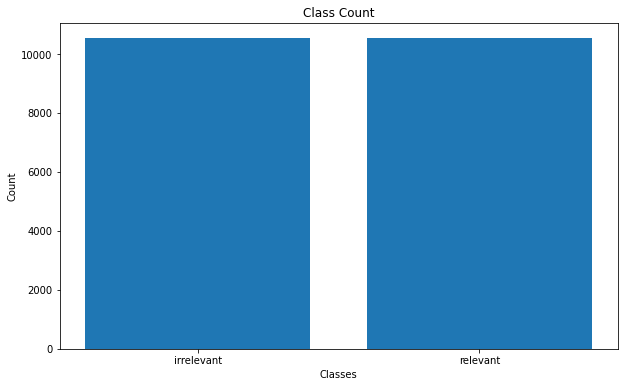

In [13]:
plot_distribution_by_class(trainset_strong, classes)

Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

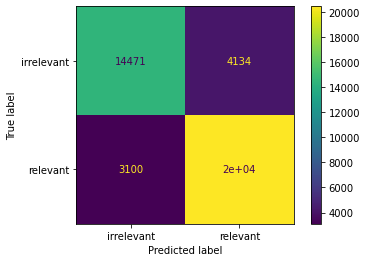

<Figure size 576x432 with 0 Axes>

val Loss: 0.2955 Acc: 0.8765
val Epoch Entropy: 0.4620
val Balanced Accuracy: 0.9000



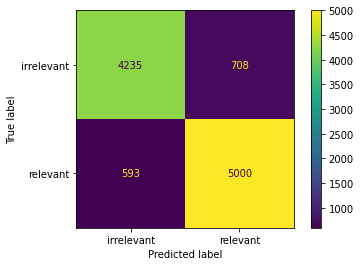

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 1/39
----------
train Loss: 0.3393 Acc: 0.8426
train Epoch Entropy: 0.4822
train Balanced Accuracy: 0.6333



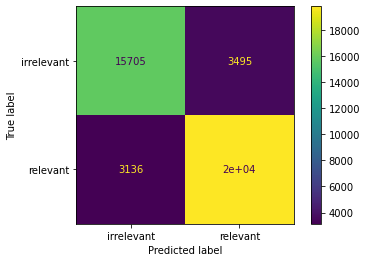

<Figure size 576x432 with 0 Axes>

val Loss: 0.2919 Acc: 0.8777
val Epoch Entropy: 0.4258
val Balanced Accuracy: 1.0000



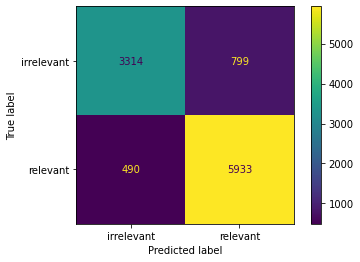

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 2/39
----------
train Loss: 0.3274 Acc: 0.8480
train Epoch Entropy: 0.4682
train Balanced Accuracy: 0.7500



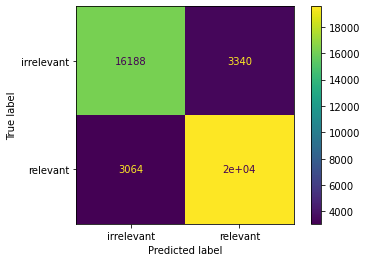

<Figure size 576x432 with 0 Axes>

val Loss: 0.2733 Acc: 0.8807
val Epoch Entropy: 0.4242
val Balanced Accuracy: 0.8750



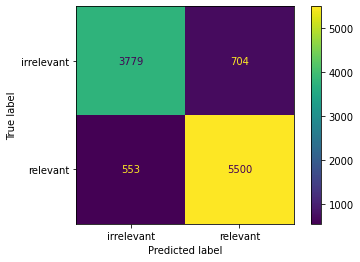

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 3/39
----------
train Loss: 0.3181 Acc: 0.8525
train Epoch Entropy: 0.4602
train Balanced Accuracy: 1.0000



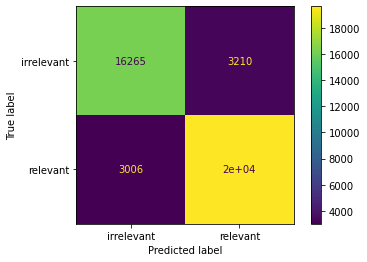

<Figure size 576x432 with 0 Axes>

val Loss: 0.2784 Acc: 0.8764
val Epoch Entropy: 0.3828
val Balanced Accuracy: 0.7500



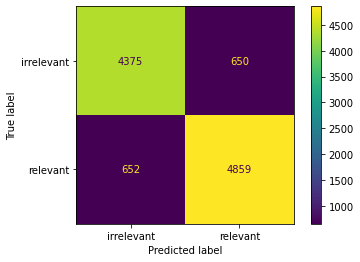

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 4/39
----------
train Loss: 0.3164 Acc: 0.8552
train Epoch Entropy: 0.4488
train Balanced Accuracy: 1.0000



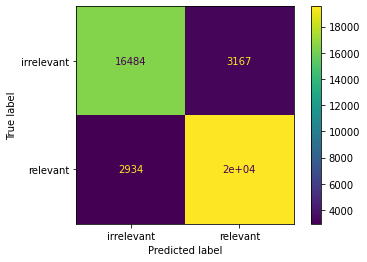

<Figure size 576x432 with 0 Axes>

val Loss: 0.2906 Acc: 0.8765
val Epoch Entropy: 0.4172
val Balanced Accuracy: 0.8333



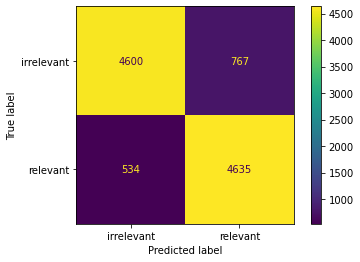

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 5/39
----------
train Loss: 0.3141 Acc: 0.8556
train Epoch Entropy: 0.4503
train Balanced Accuracy: 0.7500



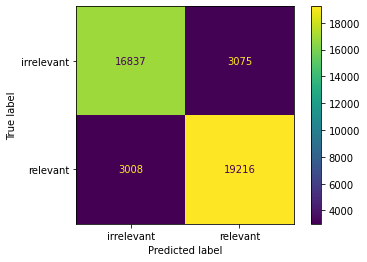

<Figure size 576x432 with 0 Axes>

val Loss: 0.2794 Acc: 0.8819
val Epoch Entropy: 0.3782
val Balanced Accuracy: 1.0000



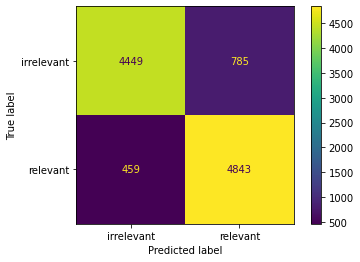

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 6/39
----------
train Loss: 0.3117 Acc: 0.8575
train Epoch Entropy: 0.4498
train Balanced Accuracy: 1.0000



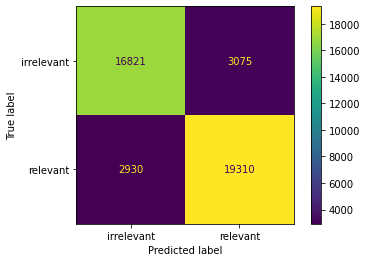

<Figure size 576x432 with 0 Axes>

val Loss: 0.2822 Acc: 0.8791
val Epoch Entropy: 0.4047
val Balanced Accuracy: 0.9000



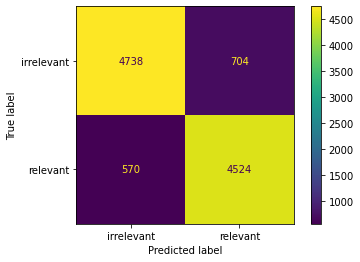

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 7/39
----------
train Loss: 0.2821 Acc: 0.8725
train Epoch Entropy: 0.4155
train Balanced Accuracy: 1.0000



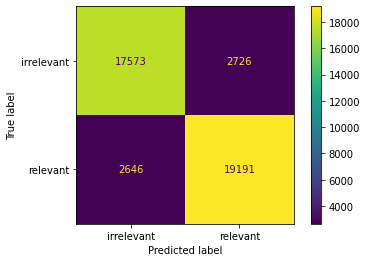

<Figure size 576x432 with 0 Axes>

val Loss: 0.2805 Acc: 0.8825
val Epoch Entropy: 0.3540
val Balanced Accuracy: 1.0000



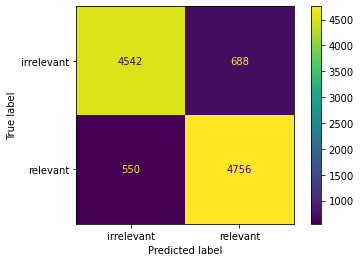

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 8/39
----------
train Loss: 0.2687 Acc: 0.8813
train Epoch Entropy: 0.3926
train Balanced Accuracy: 1.0000



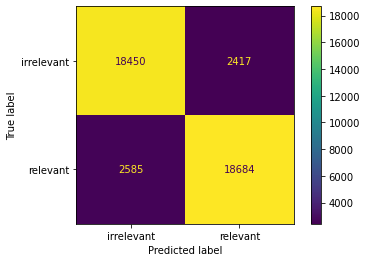

<Figure size 576x432 with 0 Axes>

val Loss: 0.2915 Acc: 0.8775
val Epoch Entropy: 0.3667
val Balanced Accuracy: 0.8000



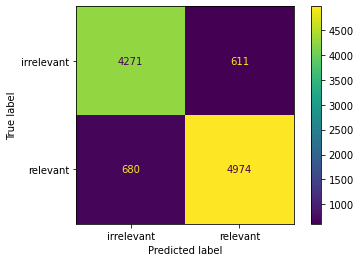

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 9/39
----------
train Loss: 0.2588 Acc: 0.8895
train Epoch Entropy: 0.3854
train Balanced Accuracy: 1.0000



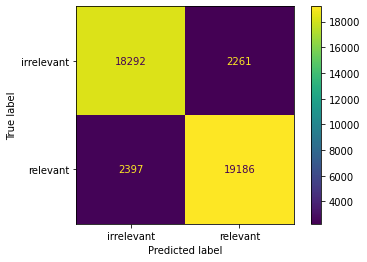

<Figure size 576x432 with 0 Axes>

val Loss: 0.2954 Acc: 0.8790
val Epoch Entropy: 0.3581
val Balanced Accuracy: 0.7333



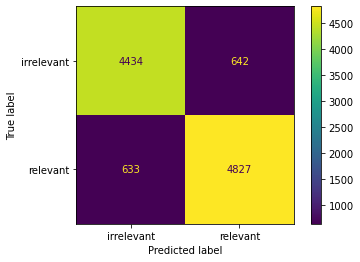

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 10/39
----------
train Loss: 0.2507 Acc: 0.8935
train Epoch Entropy: 0.3789
train Balanced Accuracy: 1.0000



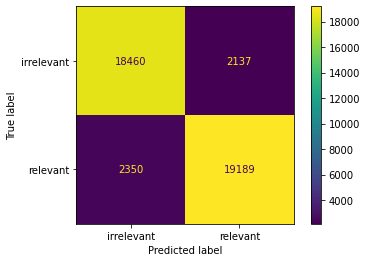

<Figure size 576x432 with 0 Axes>

val Loss: 0.3068 Acc: 0.8757
val Epoch Entropy: 0.3693
val Balanced Accuracy: 0.9000



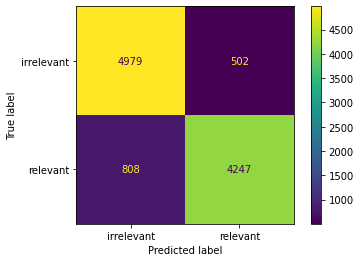

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 11/39
----------
train Loss: 0.2377 Acc: 0.8995
train Epoch Entropy: 0.3571
train Balanced Accuracy: 1.0000



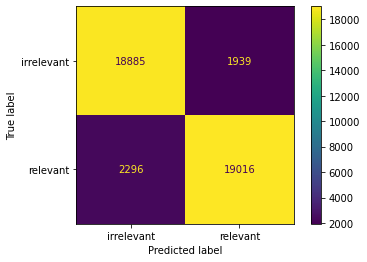

<Figure size 576x432 with 0 Axes>

val Loss: 0.3349 Acc: 0.8758
val Epoch Entropy: 0.3119
val Balanced Accuracy: 0.8333



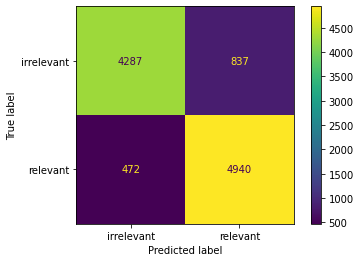

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 12/39
----------
train Loss: 0.2275 Acc: 0.9047
train Epoch Entropy: 0.3468
train Balanced Accuracy: 0.8750



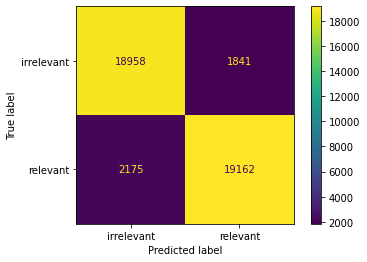

<Figure size 576x432 with 0 Axes>

val Loss: 0.3416 Acc: 0.8751
val Epoch Entropy: 0.3035
val Balanced Accuracy: 1.0000



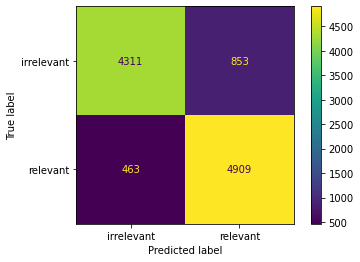

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 13/39
----------
train Loss: 0.2130 Acc: 0.9127
train Epoch Entropy: 0.3297
train Balanced Accuracy: 1.0000



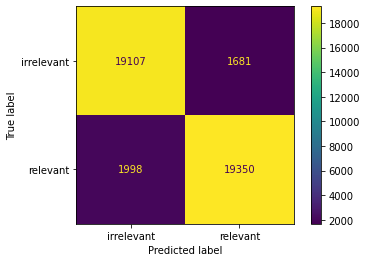

<Figure size 576x432 with 0 Axes>

val Loss: 0.3614 Acc: 0.8728
val Epoch Entropy: 0.2980
val Balanced Accuracy: 0.9286



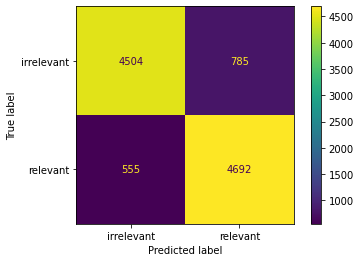

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 14/39
----------
train Loss: 0.2003 Acc: 0.9208
train Epoch Entropy: 0.3246
train Balanced Accuracy: 0.9167



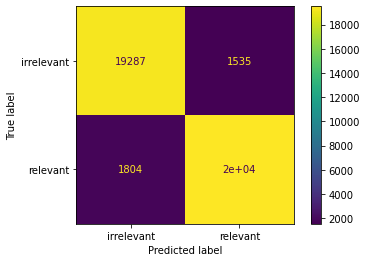

<Figure size 576x432 with 0 Axes>

val Loss: 0.3582 Acc: 0.8739
val Epoch Entropy: 0.3026
val Balanced Accuracy: 0.8571



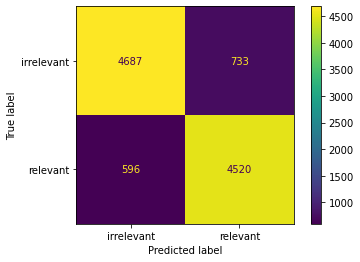

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 15/39
----------
train Loss: 0.1935 Acc: 0.9237
train Epoch Entropy: 0.3160
train Balanced Accuracy: 1.0000



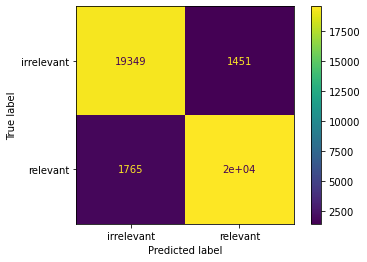

<Figure size 576x432 with 0 Axes>

val Loss: 0.3641 Acc: 0.8714
val Epoch Entropy: 0.3003
val Balanced Accuracy: 0.9167



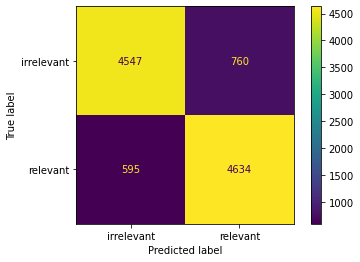

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 16/39
----------
train Loss: 0.1941 Acc: 0.9241
train Epoch Entropy: 0.3132
train Balanced Accuracy: 0.9167



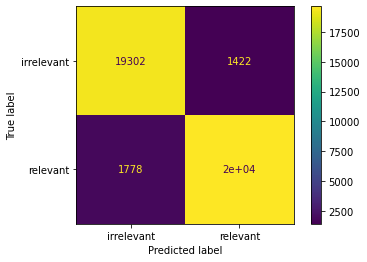

<Figure size 576x432 with 0 Axes>

val Loss: 0.3800 Acc: 0.8716
val Epoch Entropy: 0.2881
val Balanced Accuracy: 1.0000



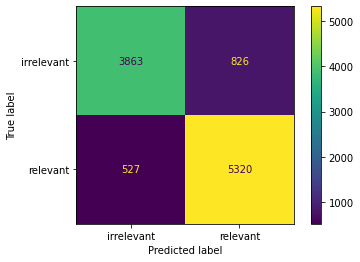

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 17/39
----------
train Loss: 0.1906 Acc: 0.9248
train Epoch Entropy: 0.3104
train Balanced Accuracy: 0.7500



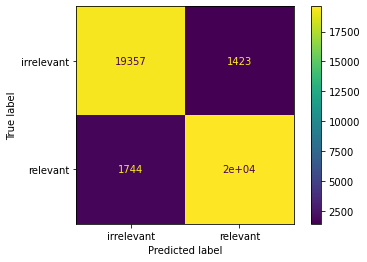

<Figure size 576x432 with 0 Axes>

val Loss: 0.3657 Acc: 0.8665
val Epoch Entropy: 0.3085
val Balanced Accuracy: 0.0000



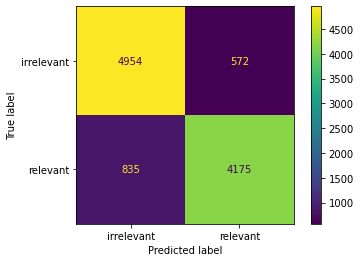

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 18/39
----------
train Loss: 0.1929 Acc: 0.9247
train Epoch Entropy: 0.3108
train Balanced Accuracy: 1.0000



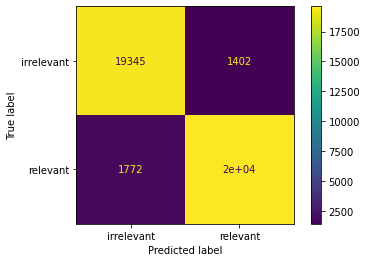

<Figure size 576x432 with 0 Axes>

val Loss: 0.3516 Acc: 0.8684
val Epoch Entropy: 0.3219
val Balanced Accuracy: 0.8333



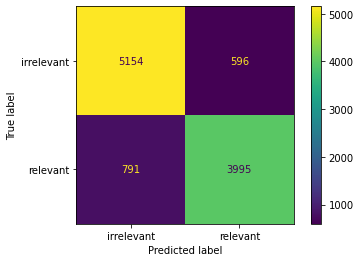

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 19/39
----------
train Loss: 0.1903 Acc: 0.9258
train Epoch Entropy: 0.3058
train Balanced Accuracy: 1.0000



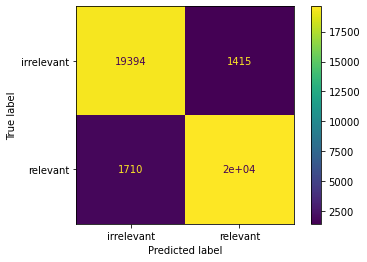

<Figure size 576x432 with 0 Axes>

val Loss: 0.3807 Acc: 0.8717
val Epoch Entropy: 0.2987
val Balanced Accuracy: 0.6667



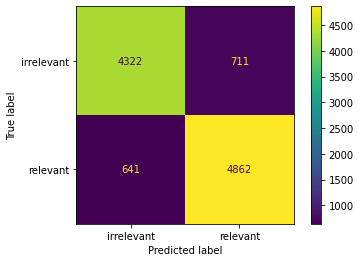

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 20/39
----------
train Loss: 0.1862 Acc: 0.9281
train Epoch Entropy: 0.3054
train Balanced Accuracy: 0.8750



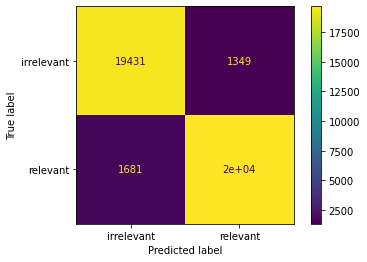

<Figure size 576x432 with 0 Axes>

val Loss: 0.3716 Acc: 0.8712
val Epoch Entropy: 0.3090
val Balanced Accuracy: 0.9000



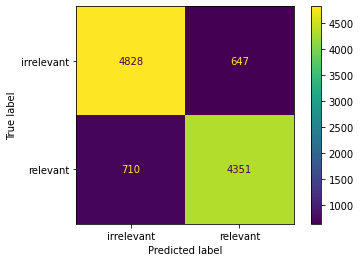

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 21/39
----------
train Loss: 0.1874 Acc: 0.9262
train Epoch Entropy: 0.3022
train Balanced Accuracy: 0.8750



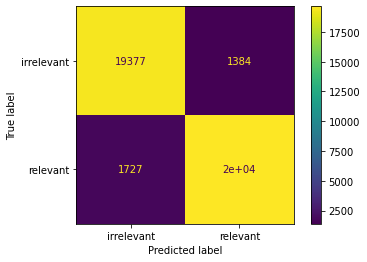

<Figure size 576x432 with 0 Axes>

val Loss: 0.3702 Acc: 0.8685
val Epoch Entropy: 0.3128
val Balanced Accuracy: 0.8750



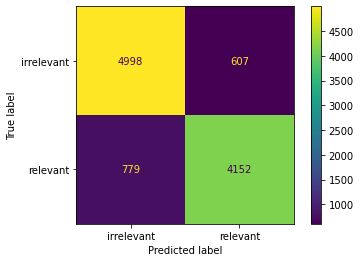

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 22/39
----------
train Loss: 0.1855 Acc: 0.9269
train Epoch Entropy: 0.3035
train Balanced Accuracy: 0.9167



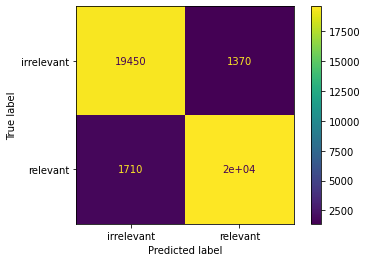

<Figure size 576x432 with 0 Axes>

val Loss: 0.3984 Acc: 0.8721
val Epoch Entropy: 0.2812
val Balanced Accuracy: 1.0000



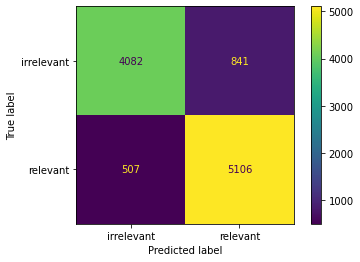

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 23/39
----------
train Loss: 0.1864 Acc: 0.9281
train Epoch Entropy: 0.3035
train Balanced Accuracy: 1.0000



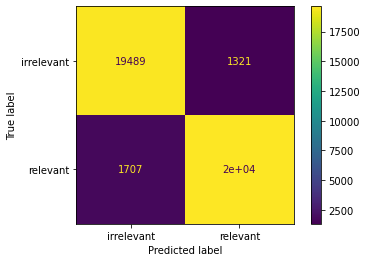

<Figure size 576x432 with 0 Axes>

val Loss: 0.4047 Acc: 0.8722
val Epoch Entropy: 0.2777
val Balanced Accuracy: 0.6667



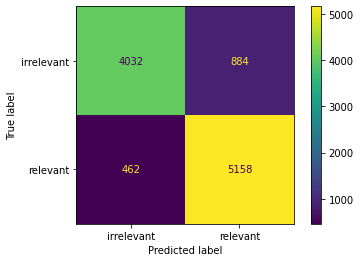

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 24/39
----------
train Loss: 0.1877 Acc: 0.9261
train Epoch Entropy: 0.3039
train Balanced Accuracy: 0.9000



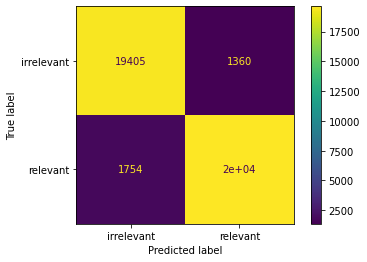

<Figure size 576x432 with 0 Axes>

val Loss: 0.3702 Acc: 0.8611
val Epoch Entropy: 0.3266
val Balanced Accuracy: 0.7333



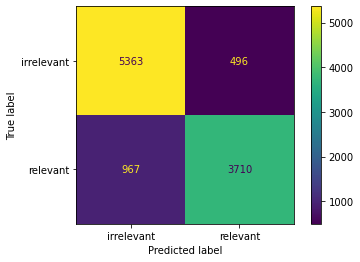

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 25/39
----------
train Loss: 0.1875 Acc: 0.9280
train Epoch Entropy: 0.3029
train Balanced Accuracy: 0.9000



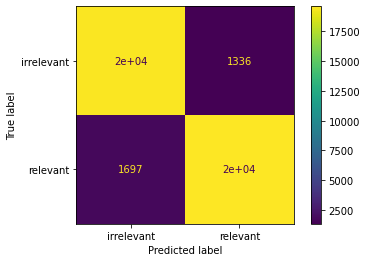

<Figure size 576x432 with 0 Axes>

val Loss: 0.3797 Acc: 0.8719
val Epoch Entropy: 0.2881
val Balanced Accuracy: 0.8000



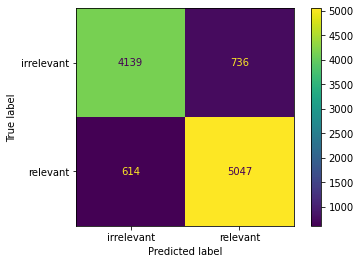

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 26/39
----------
train Loss: 0.1867 Acc: 0.9281
train Epoch Entropy: 0.3038
train Balanced Accuracy: 1.0000



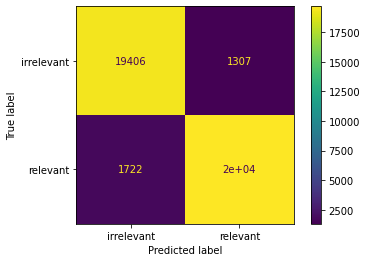

<Figure size 576x432 with 0 Axes>

val Loss: 0.3693 Acc: 0.8656
val Epoch Entropy: 0.3237
val Balanced Accuracy: 0.7333



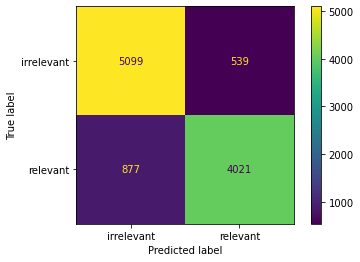

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 27/39
----------
train Loss: 0.1871 Acc: 0.9275
train Epoch Entropy: 0.3012
train Balanced Accuracy: 0.9167



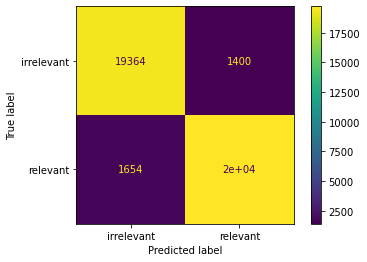

<Figure size 576x432 with 0 Axes>

val Loss: 0.3669 Acc: 0.8691
val Epoch Entropy: 0.3222
val Balanced Accuracy: 0.8000



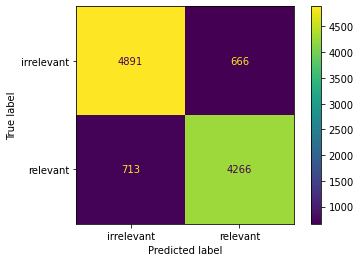

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 28/39
----------
train Loss: 0.1865 Acc: 0.9267
train Epoch Entropy: 0.3026
train Balanced Accuracy: 0.8750



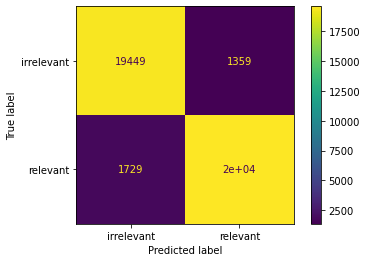

<Figure size 576x432 with 0 Axes>

val Loss: 0.3866 Acc: 0.8722
val Epoch Entropy: 0.2988
val Balanced Accuracy: 0.7500



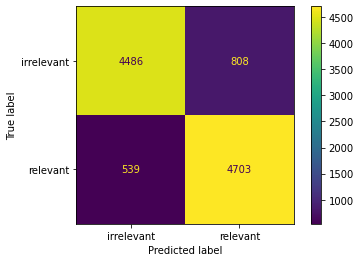

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 29/39
----------
train Loss: 0.1858 Acc: 0.9268
train Epoch Entropy: 0.3017
train Balanced Accuracy: 0.8750



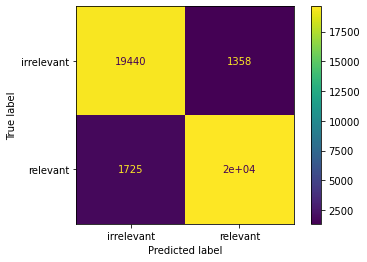

<Figure size 576x432 with 0 Axes>

val Loss: 0.3790 Acc: 0.8698
val Epoch Entropy: 0.3075
val Balanced Accuracy: 0.8750



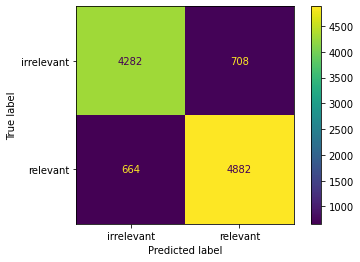

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 30/39
----------
train Loss: 0.1842 Acc: 0.9286
train Epoch Entropy: 0.3017
train Balanced Accuracy: 1.0000



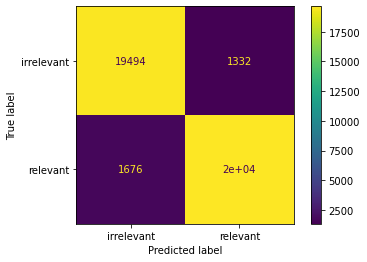

<Figure size 576x432 with 0 Axes>

val Loss: 0.3734 Acc: 0.8685
val Epoch Entropy: 0.3058
val Balanced Accuracy: 0.9000



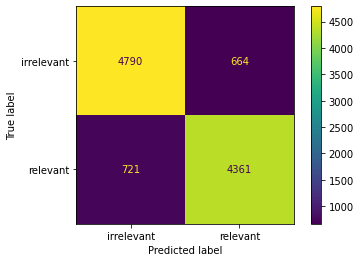

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 31/39
----------
train Loss: 0.1876 Acc: 0.9264
train Epoch Entropy: 0.3014
train Balanced Accuracy: 1.0000



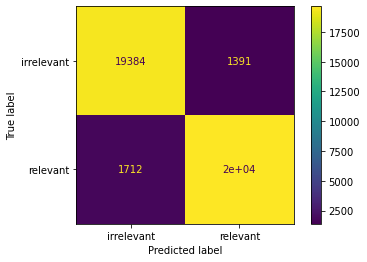

<Figure size 576x432 with 0 Axes>

val Loss: 0.3702 Acc: 0.8705
val Epoch Entropy: 0.3143
val Balanced Accuracy: 0.7333



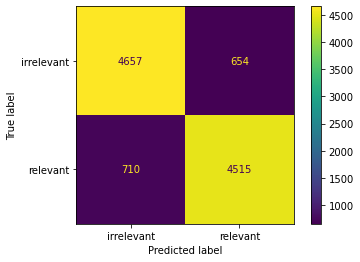

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 32/39
----------
train Loss: 0.1882 Acc: 0.9287
train Epoch Entropy: 0.3044
train Balanced Accuracy: 0.8750



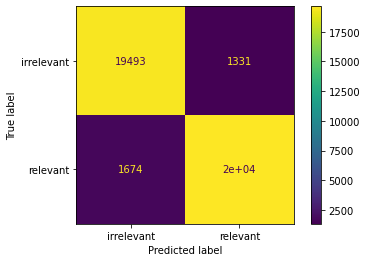

<Figure size 576x432 with 0 Axes>

val Loss: 0.3674 Acc: 0.8645
val Epoch Entropy: 0.3259
val Balanced Accuracy: 0.5000



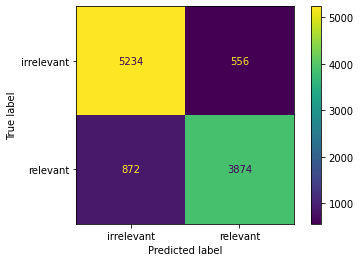

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 33/39
----------
train Loss: 0.1875 Acc: 0.9270
train Epoch Entropy: 0.3031
train Balanced Accuracy: 1.0000



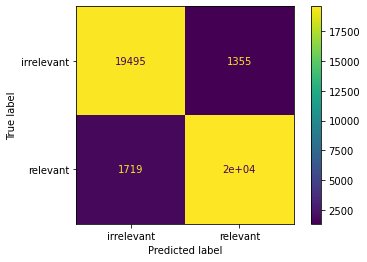

<Figure size 576x432 with 0 Axes>

val Loss: 0.3733 Acc: 0.8702
val Epoch Entropy: 0.3047
val Balanced Accuracy: 0.9000



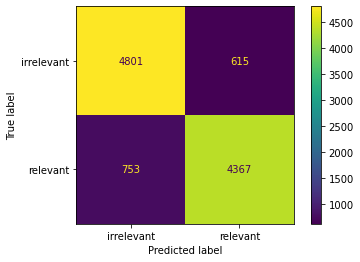

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 34/39
----------
train Loss: 0.1860 Acc: 0.9282
train Epoch Entropy: 0.3040
train Balanced Accuracy: 0.8750



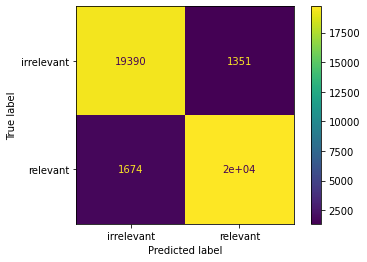

<Figure size 576x432 with 0 Axes>

val Loss: 0.3674 Acc: 0.8643
val Epoch Entropy: 0.3285
val Balanced Accuracy: 0.9167



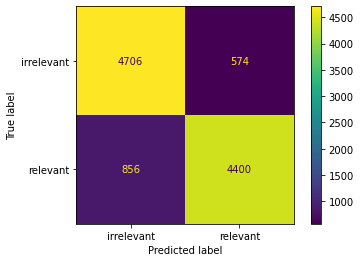

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 35/39
----------
train Loss: 0.1862 Acc: 0.9273
train Epoch Entropy: 0.3017
train Balanced Accuracy: 1.0000



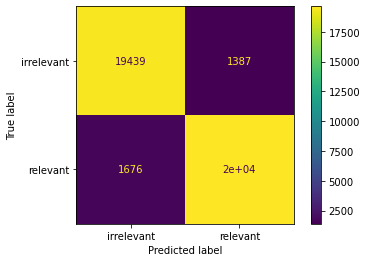

<Figure size 576x432 with 0 Axes>

val Loss: 0.3659 Acc: 0.8699
val Epoch Entropy: 0.3022
val Balanced Accuracy: 0.8750



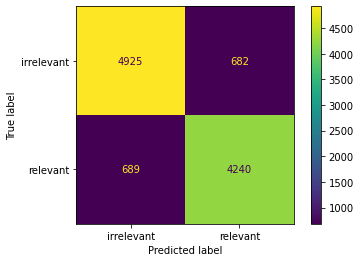

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 36/39
----------
train Loss: 0.1870 Acc: 0.9277
train Epoch Entropy: 0.3019
train Balanced Accuracy: 1.0000



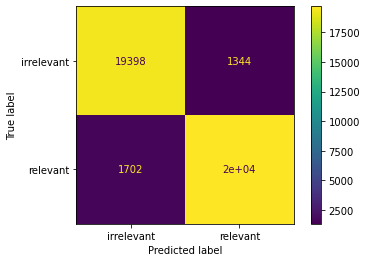

<Figure size 576x432 with 0 Axes>

val Loss: 0.3710 Acc: 0.8688
val Epoch Entropy: 0.3106
val Balanced Accuracy: 1.0000



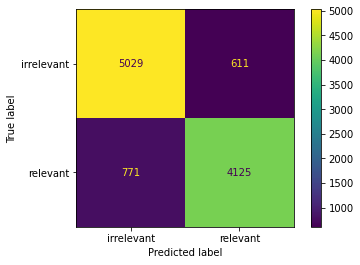

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 37/39
----------
train Loss: 0.1889 Acc: 0.9269
train Epoch Entropy: 0.3023
train Balanced Accuracy: 0.8750



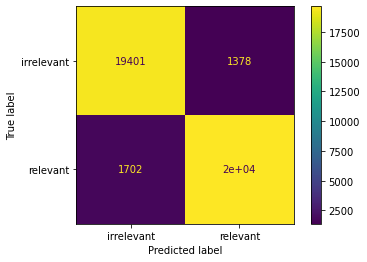

<Figure size 576x432 with 0 Axes>

val Loss: 0.3656 Acc: 0.8673
val Epoch Entropy: 0.3335
val Balanced Accuracy: 0.7500



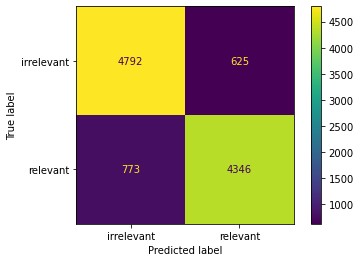

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 38/39
----------
train Loss: 0.1865 Acc: 0.9270
train Epoch Entropy: 0.3024
train Balanced Accuracy: 0.9000



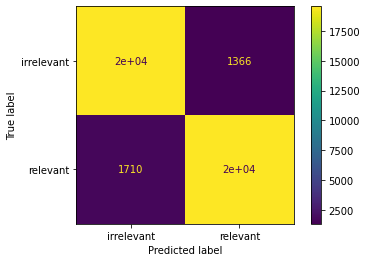

<Figure size 576x432 with 0 Axes>

val Loss: 0.3742 Acc: 0.8597
val Epoch Entropy: 0.3314
val Balanced Accuracy: 0.7333



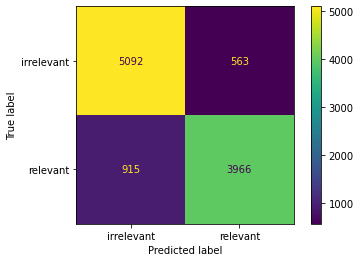

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 39/39
----------
train Loss: 0.1841 Acc: 0.9282
train Epoch Entropy: 0.3032
train Balanced Accuracy: 1.0000



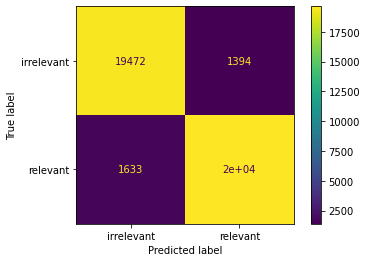

<Figure size 576x432 with 0 Axes>

val Loss: 0.3698 Acc: 0.8701
val Epoch Entropy: 0.3116
val Balanced Accuracy: 0.8750



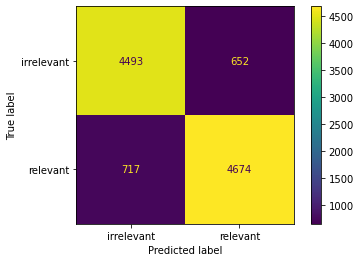

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Training complete in 338m 1s
Best val Acc: 0.882498


In [14]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset_strong, valset_strong,trainset_weak,valset_weak, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.7029, device='cuda:0')
The Test Balanced Accuracy: 0.7028829604130808


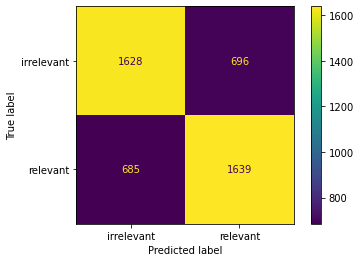

<Figure size 576x432 with 0 Axes>

In [15]:
test_model(model, testset_strong)


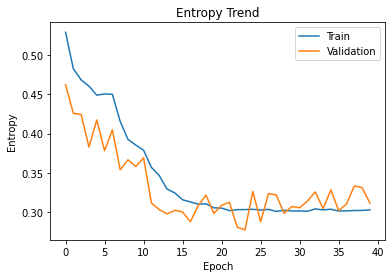

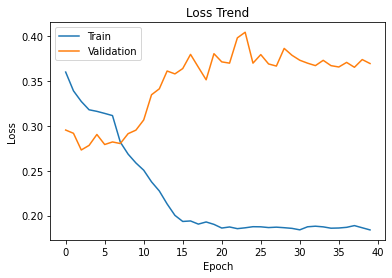

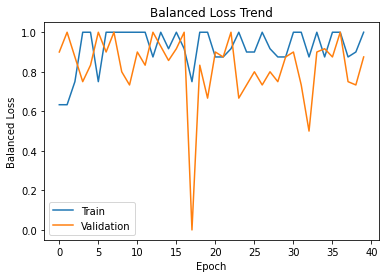

In [16]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [17]:
train_X, train_Y = weighted_score_array(model,model_list, trainset_strong, trainset_weak)
test_X, test_Y = weighted_score_array(model,model_list, testset_strong, testset_strong)


In [18]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.5092512908777969


Accuracy for SVM: 0.8392857142857143
Balanced Accuracy:0.8392863218492485


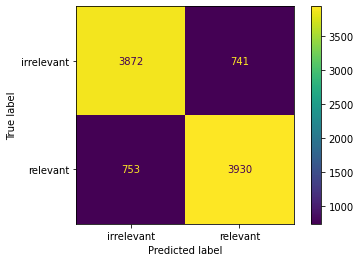

<Figure size 576x432 with 0 Axes>

In [19]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.8421901893287436
Balanced Accuracy:0.8421528876117633


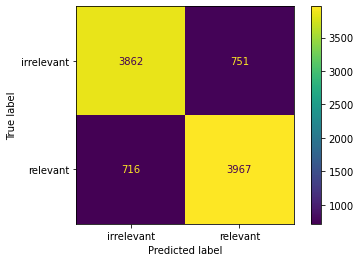

<Figure size 576x432 with 0 Axes>

In [20]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()